# Arbeitsblatt 2: Lineare Regression, Eigengesichter und Bayes-Klassifikator

## 1. Linear Regression on Fish Data

The following data-set contains the number of fish groups of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish caught by a fishing party from the following information:

* how many people are in the group
* the number children in the group
* the use of live bait
* whether the group came with a camper to the park.

We have a small data set, of 250 groups, which visited a state park and provided. For comparison the data set is already split into a training set and testset.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve

if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz', filename='fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt']  #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


In [3]:
pd.DataFrame(Xt, columns=['livebait', 'camper', 'persons', 'child'])

,livebait,camper,persons,child
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0
2,1.0,1.0,3.0,0.0
3,1.0,1.0,3.0,2.0
4,1.0,1.0,4.0,1.0
...,...,...,...,...
195,1.0,1.0,1.0,0.0
196,1.0,1.0,1.0,0.0
197,1.0,1.0,3.0,0.0
198,1.0,0.0,1.0,0.0


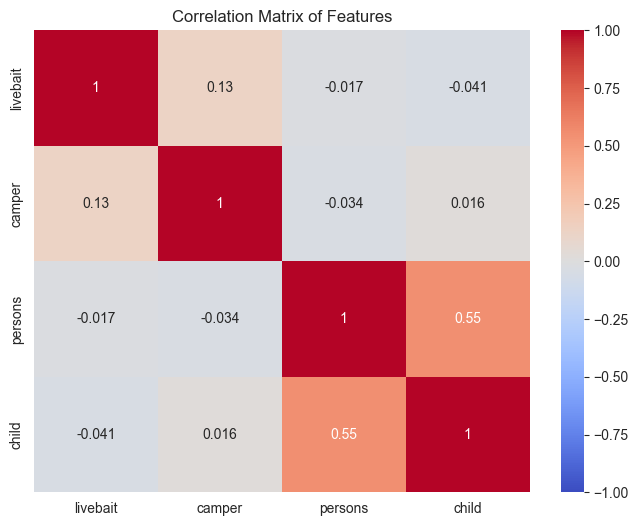

In [3]:
# correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

corr = pd.DataFrame(Xt, columns=['livebait', 'camper', 'persons', 'child']).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

a) Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.

In [4]:
import numpy as np

X_design = np.column_stack([np.ones((Xt.shape[0], 1)), Xt])

# Normale Gleichung (mit Fallback auf Pseudoinverse)
A = X_design.T @ X_design
b = X_design.T @ yt
try:
    beta_hat = np.linalg.solve(A, b)
except np.linalg.LinAlgError:
    beta_hat = np.linalg.pinv(X_design) @ yt

# Alternative direkt per Pseudoinverse (numerisch stabil)
beta_pinv = np.linalg.pinv(X_design) @ yt

# Vorhersage und RMSE
y_pred = X_design @ beta_hat
rmse_train = np.sqrt(np.mean((yt - y_pred) ** 2))

print("Estimated coefficients (intercept first):")
print(beta_hat)
print()
print("Estimated coefficients via pinv (for comparison):")
print(beta_pinv)
print()
print(f"Train RMSE: {rmse_train:.6f}")

# Interpretation der Ausgaben
# β0 (erstes Element): geschätztes Basisergebnis (wenn alle Features = 0).
# β1..β4: Einheitenänderung in der Vorhersage, wenn das jeweilige Feature um 1 zunimmt (unter Annahme aller anderen konstant).
# Vorzeichen: positiv → steigende Featurewerte erhöhen erwarteten y, negativ → verringern.
# RMSE: typischer Abstand zwischen tatsächlichen und vorhergesagten Werten; sinnvoll zum Vergleichen verschiedener Modelle.

Estimated coefficients (intercept first):
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]

Estimated coefficients via pinv (for comparison):
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]

Train RMSE: 10.829103


b) Repeat a) but this time with `LinearRegression` from `sklearn.linear_model`

In [5]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(Xt, yt)

# sklearn trennt intercept und koeffizienten
beta_sklearn = np.hstack([lr.intercept_, lr.coef_])

# Vorhersage und RMSE
y_pred_lr = lr.predict(Xt)
rmse_lr = np.sqrt(np.mean((yt - y_pred_lr) ** 2))

print("Sklearn LinearRegression coefficients (intercept first):")
print(beta_sklearn)
print()
print(f"Train RMSE (sklearn): {rmse_lr:.6f}")
print()

print("Closed-form coefficients for comparison:")
print(beta_hat)
print("Difference (sklearn - closed-form):")
print(beta_sklearn - beta_hat)

# Interpretation der Ausgaben
# Die geschätzten Koeffizienten von sklearn sollten sehr ähnlich zu denen aus der geschlossenen Form sein.
# Kleine Unterschiede können durch numerische Rundungsfehler oder unterschiedliche Implementierungsdetails


Sklearn LinearRegression coefficients (intercept first):
[-8.492231   2.4822128  2.9543095  4.6495404 -5.4716005]

Train RMSE (sklearn): 10.829104

Closed-form coefficients for comparison:
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]
Difference (sklearn - closed-form):
[-3.16059879e-06 -1.01801540e-06  2.19840133e-06  1.28578622e-06
 -1.97414884e-08]


c) Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) $p(y|x)$ is given by the density of a Gaussian with constant variance $\sigma^2$. The slope and the intercept of the linear model can be estimated as shown in the lecture. To estimate $\sigma^2$ you can use the variance of the residuals. Use the variance estimation with $1/N$.

In [6]:
# Build design matrix for testset
Xte_design = np.column_stack([np.ones((Xte.shape[0], 1)), Xte])

# Predictions on test set
y_pred_test = Xte_design @ beta_hat
rmse_test = np.sqrt(np.mean((yte - y_pred_test) ** 2))

# Estimate sigma^2 from training residuals using 1/N
# (use the model fitted on training data)
X_design_train = np.column_stack([np.ones((Xt.shape[0], 1)), Xt])
resid_train = yt - (X_design_train @ beta_hat)
sigma2 = np.mean(resid_train ** 2)  # 1/N variance estimator

# Average negative log-likelihood on the testset (Gaussian with constant variance)
# For a single data point: NLL_i = 0.5 * log(2*pi*sigma2) + (y_i - mu_i)^2 / (2*sigma2)
nlls = 0.5 * np.log(2 * np.pi * sigma2) + ((yte - y_pred_test) ** 2) / (2 * sigma2)
avg_nll = np.mean(nlls)

print(f"Test RMSE: {rmse_test:.6f}")
print(f"Estimated sigma^2 (from training residuals, 1/N): {sigma2:.6f}")
print(f"Average NLL on testset: {avg_nll:.6f}")

# Interpretation der Ausgaben
# Test RMSE: typischer Abstand zwischen tatsächlichen und vorhergesagten Werten auf
# dem Testset; gibt Aufschluss über die Generalisierungsfähigkeit des Modells.
# Geschätzte sigma^2: Varianz der Residuen auf dem Trainingsset; gibt an, wie stark die
# tatsächlichen Werte um die Vorhersagen streuen.
# Durchschnittliche NLL: Maß für die Güte der Wahrscheinlichkeitsvorhersagen des
# Modells auf dem Testset; niedrigere Werte deuten auf bessere Vorhersagen hin

Test RMSE: 8.588126
Estimated sigma^2 (from training residuals, 1/N): 117.269478
Average NLL on testset: 3.615648


d) In a)-c) you have trained a probabilistic model $p(y|x) = N(y | \hat{\beta} x, \hat{\sigma}^2)$. With $N(y|\mu,\sigma^2)$, we denote the density of the Gaussian distribution with mean \mu and variance \sigma^2. Given, a value $x$ you get a conditional predictive distribution (CPD) $p(y|x)$. How to make a sensefull plot of the CPD?

Note, since $x$ is not a scalar quantity, we cannot plot against the $x$ on the x-axis. So for each pair $y_i, x_i$ of the testset, we use the expactation $\hat{\mu_i} = \mathbb{E}(p(y|x_i))$ (predicted mean) instead of the $x_i$ on the x-axis. On the y-axis, we like to compare the observed value $y_i$ with the result from the model. We could plot $p(y|x_i)$, but that would get too messy with many datapoints in the testet. Instead, we therefore plot $\hat{\mu_i}$ and the 2.5 and 97.5 precentile of $p(y|x_i)$. Such a a plot is sometimes called a **prediction interval plot**


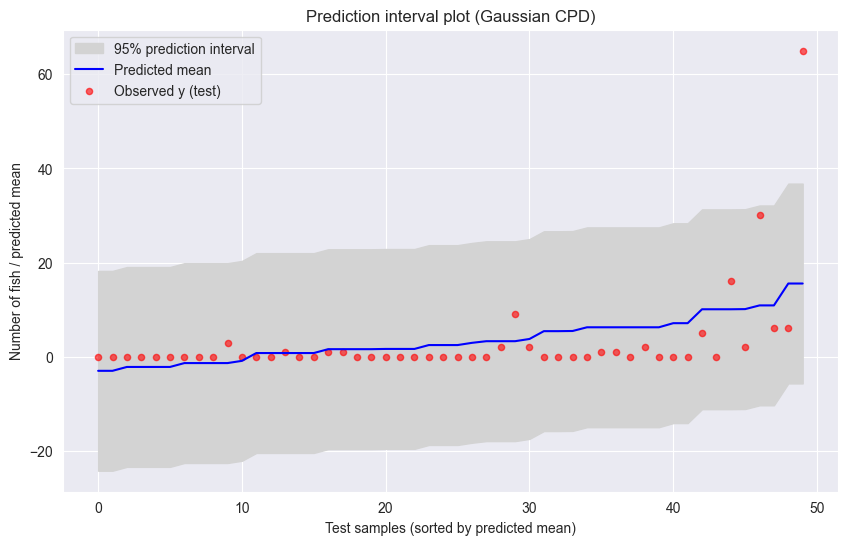

In [7]:
import matplotlib.pyplot as plt

# predicted means on test set
mu_test = y_pred_test
sigma = np.sqrt(sigma2)

# 95% interval for Gaussian: mu +/- 1.96 * sigma
lower = mu_test - 1.96 * sigma
upper = mu_test + 1.96 * sigma

# Sort by predicted mean for nicer plotting
order = np.argsort(mu_test)
mu_sorted = mu_test[order]
y_sorted = yte[order]
lower_sorted = lower[order]
upper_sorted = upper[order]

plt.figure(figsize=(10, 6))
plt.fill_between(range(len(mu_sorted)), lower_sorted, upper_sorted, color='lightgray', label='95% prediction interval')
plt.plot(range(len(mu_sorted)), mu_sorted, 'b-', label='Predicted mean')
plt.scatter(range(len(mu_sorted)), y_sorted, c='red', s=20, alpha=0.6, label='Observed y (test)')
plt.xlabel('Test samples (sorted by predicted mean)')
plt.ylabel('Number of fish / predicted mean')
plt.title('Prediction interval plot (Gaussian CPD)')
plt.legend()
plt.show()


e) This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal.

Now use a model with Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 \text{NLL} = -\log(p(k)) = \mu  - k \cdot \log(\mu) + \log(k!)
$$

with $\mu$ being the expectation. In our case the average number of fish expected.


In [8]:
from scipy.special import gammaln

# Design matrix for training and test (already built above as X_design and Xte_design)
beta_poisson = np.ones(X_design.shape[1])

lr = 0.001
epochs = 5000
N = Xt.shape[0]

for epoch in range(epochs):
    # linear predictor and mean
    eta = X_design @ beta_poisson
    # to keep numerics stable, clip eta
    eta = np.clip(eta, -20, 20)
    mu = np.exp(eta)

    # Negative log-likelihood and gradient (sum over data points)
    # NLL = sum(mu - y * log(mu) + log(y!)) ; gradient = X.T @ (mu - y)
    grad = X_design.T @ (mu - yt)

    beta_poisson -= lr * grad / N

    # optional: print progress every 500 epochs
    if (epoch + 1) % 500 == 0:
        nll = np.sum(mu - yt * np.log(mu + 1e-12) + (gammaln(yt + 1)))
        print(f"Epoch {epoch + 1}/{epochs}: NLL (train, approx) = {nll:.2f}")

# Final training NLL
eta_train = np.clip(X_design @ beta_poisson, -20, 20)
mu_train = np.exp(eta_train)
train_nll = np.sum(mu_train - yt * np.log(mu_train + 1e-12) + (gammaln(yt + 1)))

# Predictions on test set (use mu as predictive mean)
eta_test = np.clip(Xte_design @ beta_poisson, -20, 20)
mu_test_poisson = np.exp(eta_test)
rmse_poisson = np.sqrt(np.mean((yte - mu_test_poisson) ** 2))

test_nlls = mu_test_poisson - yte * np.log(mu_test_poisson + 1e-12) + gammaln(yte + 1)

avg_test_nll_poisson = np.mean(test_nlls)

print('\nPoisson regression results:')
print('Estimated beta (intercept first):', beta_poisson)
print(f'Train NLL (sum): {train_nll:.2f}')
print(f'Test RMSE (mean predictions): {rmse_poisson:.6f}')
print(f'Average test NLL (per datapoint): {avg_test_nll_poisson:.6f}')


Epoch 500/5000: NLL (train, approx) = 1074.86
Epoch 1000/5000: NLL (train, approx) = 833.67
Epoch 1500/5000: NLL (train, approx) = 772.13
Epoch 2000/5000: NLL (train, approx) = 746.18
Epoch 2500/5000: NLL (train, approx) = 731.38
Epoch 3000/5000: NLL (train, approx) = 721.30
Epoch 3500/5000: NLL (train, approx) = 713.70
Epoch 4000/5000: NLL (train, approx) = 707.63
Epoch 4500/5000: NLL (train, approx) = 702.61
Epoch 5000/5000: NLL (train, approx) = 698.36

Poisson regression results:
Estimated beta (intercept first): [-1.08852056  0.2597268   0.54509109  0.85448041 -1.65101241]
Train NLL (sum): 698.35
Test RMSE (mean predictions): 7.606839
Average test NLL (per datapoint): 3.069287


f) Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.

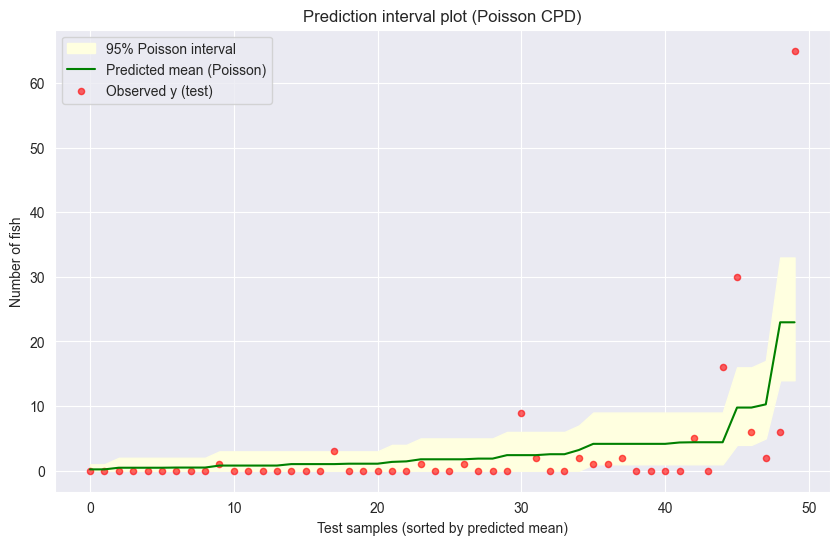

In [9]:
from scipy.stats import poisson

lower_p = poisson.ppf(0.025, mu_test_poisson)
upper_p = poisson.ppf(0.975, mu_test_poisson)

# sort by predicted mean for plotting
order_p = np.argsort(mu_test_poisson)
mu_p_sorted = mu_test_poisson[order_p]
y_p_sorted = yte[order_p]
lower_p_sorted = lower_p[order_p]
upper_p_sorted = upper_p[order_p]

plt.figure(figsize=(10, 6))
plt.fill_between(range(len(mu_p_sorted)), lower_p_sorted, upper_p_sorted, color='lightyellow',
                 label='95% Poisson interval')
plt.plot(range(len(mu_p_sorted)), mu_p_sorted, 'g-', label='Predicted mean (Poisson)')
plt.scatter(range(len(mu_p_sorted)), y_p_sorted, c='red', s=20, alpha=0.6, label='Observed y (test)')
plt.xlabel('Test samples (sorted by predicted mean)')
plt.ylabel('Number of fish')
plt.title('Prediction interval plot (Poisson CPD)')
plt.legend()
plt.show()



## 2. Eigengesichter
Die Hauptkomponentenanalyse lässt sich auch auf Bilder anwenden, indem man die Bildzeilen in einem einzigen Vektor aneinander hängt (*Stacking*). Die zugehörigen Richtungen extremaler Varianz heißen *Eigengesichter*. Sie eignen sich nicht nur zur Datenkompression, sondern auch zum Aufbau eines einfachen Gesichtserkennungssystems (s. M. Turk and A. Pentland, “Eigenfaces for Recognition”, Journal of Cognitive Neuroscience, vol. 3, no. 1, pp. 71–86, 1991). Für die Funktion eines solchen Systems ist es wichtig, dass die Gesichter zentriert und in derselben Größe abgebildet sind. Ein dafür geeigneter Datensatz ist ''Labeled Faces in the Wild'' der Universität von Massachusetts in Amherst (`http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz`, 233MB) mit Bildern von 13.000 Personen des öffentlichen Lebens aus dem Internet, alle mit Namen gelabelt.

Aufgaben:

a) Laden Sie sich den oben angegebenen Datensatz herunter. Erstellen Sie ein Python- Skript, dass die Verzeichnisse des Datensatzes durchsucht und die Personen ermittelt, für die mindestens 70 Bilder existieren. Die dafür geeigneten Funktionen finden sich im Standardmodul `os` bzw. `os.path`.

In [10]:
import kagglehub
import shutil
import os

# Aktuelles Arbeitsverzeichnis bestimmen
current_dir = os.getcwd()
target_dir = os.path.join(current_dir, "lfw-funneled")

# 1) Download mit kagglehub
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Dataset wurde geladen unter:", path)

# 2) Wenn Zielordner noch nicht existiert → kopieren
if not os.path.exists(target_dir):
    shutil.copytree(path, target_dir)
    print("Daten wurden kopiert nach:", target_dir)
else:
    print("Zielordner existiert bereits:", target_dir)

C:\Users\osibo\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 112M/112M [00:11<00:00, 10.3MB/s] 

Extracting files...


Dataset wurde geladen unter: C:\Users\osibo\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4
Daten wurden kopiert nach: E:\_MSC\ML\blatt2\lfw-funneled


In [13]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.metrics import confusion_matrix, classification_report

# Pfad zum LFW-Funneled-Ordner (anpassen falls nötig)
lfw_dir = 'lfw-funneled/lfw-deepfunneled/lfw-deepfunneled'

# Ermittle alle Personen-Ordner und die Anzahl Bilder pro Person
people = [p for p in os.listdir(lfw_dir) if os.path.isdir(os.path.join(lfw_dir, p))]
counts = {p: len(glob.glob(os.path.join(lfw_dir, p, '*.jpg'))) for p in people}

# Personen mit >= 70 Bildern
selected_people = sorted([p for p, c in counts.items() if c >= 70])

print(f'Found {len(selected_people)} people with >=70 images')
for p in selected_people:
    print(p, counts[p])


Found 7 people with >=70 images
Ariel_Sharon 77
Colin_Powell 236
Donald_Rumsfeld 121
George_W_Bush 530
Gerhard_Schroeder 109
Hugo_Chavez 71
Tony_Blair 144


b) Erstellen Sie ein Python-Skript, das alle Bilder bis auf eines pro Person (diese werden später zum Testen des Klassifikators gebraucht) dieser am häufigsten abgebildeten Personen lädt, diese in Vektoren stackt und dann in einer gemeinsamen Designmatrix ablegt. Zum Laden der Bilder in Numpy-Arrays verwenden Sie am einfachsten das Modul `scikit-image`. Schneiden Sie zunächst einen einheitlichen zentralen Ausschnitt aus, der nur Augen und Mund enthält. Skalieren Sie die Bilder auf die Größe 32 × 32. Achten Sie darauf, vorher die Farbbilder in Grauwerte umzuwandeln (z.B. mit der Option `as_gray = True`) Legen Sie zusätzlich einen Vektor an, in dem der Name der Person (d.h. der Ordnername) für jede Zeile steht. Führen Sie die gleiche Art der Verarbeitung mit dem übrig gebliebenen Testbild pro Person durch und speichern Sie diese getrennt ab.

In [17]:


IMG_SIZE = 32

X_train = []
Y_train = []
X_test = []
Y_test = []
person_to_label = {p: i for i, p in enumerate(selected_people)}


def preprocess_image(img, size=IMG_SIZE):
    # convert to grayscale if needed
    if img.ndim == 3:
        img = skimage.color.rgb2gray(img)
    # center-crop to square
    h, w = img.shape
    m = min(h, w)
    top = (h - m) // 2
    left = (w - m) // 2
    img_cropped = img[top:top + m, left:left + m]
    # resize to size x size
    img_resized = skimage.transform.resize(img_cropped, (size, size), anti_aliasing=True)
    return img_resized


for person in selected_people:
    files = sorted(glob.glob(os.path.join(lfw_dir, person, '*.jpg')))
    if len(files) < 2:
        continue
    # Reserve the last image as test image (deterministic)
    test_file = files[-1]
    train_files = files[:-1]

    # Load test image
    img = imread(test_file)
    img_p = preprocess_image(img)
    X_test.append(img_p.ravel())
    Y_test.append(person_to_label[person])

    # Load training images
    for f in train_files:
        img = imread(f)
        img_p = preprocess_image(img)
        X_train.append(img_p.ravel())
        Y_train.append(person_to_label[person])

X_train = np.vstack(X_train)
Y_train = np.array(Y_train)
X_test = np.vstack(X_test)
Y_test = np.array(Y_test)

print('\nTraining set shape:', X_train.shape)
print('Test set shape:', X_test.shape)



Training set shape: (1281, 1024)
Test set shape: (7, 1024)


c) Wenden Sie nun Ihre Hauptkomponentenanalyse aus Arbeitsblatt 1 auf Ihre Designmatrix (Achtung: kopieren Sie alle Trainingsbilder für alle Personen als Zeilen in eine gemeinsame Designmatrix!) an. Stellen Sie die ersten 150 Eigenwerte in einem Diagramm und die ersten 12 Eigengesichter durch Umformung der gestackten Darstellung in das ursprüngliche Bildformat
dar. Interpretieren Sie das Ergebnis.

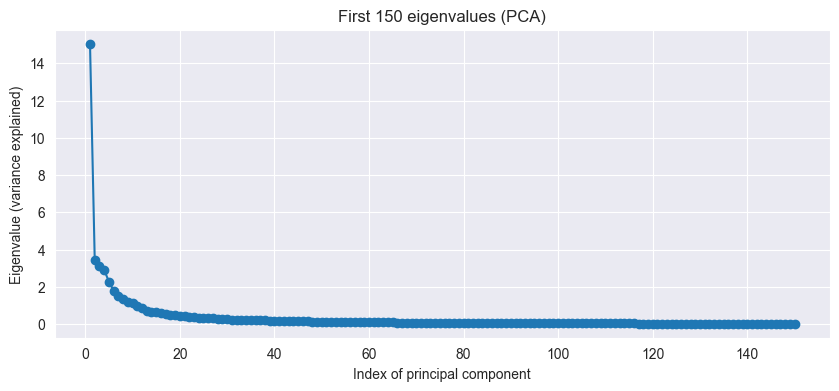

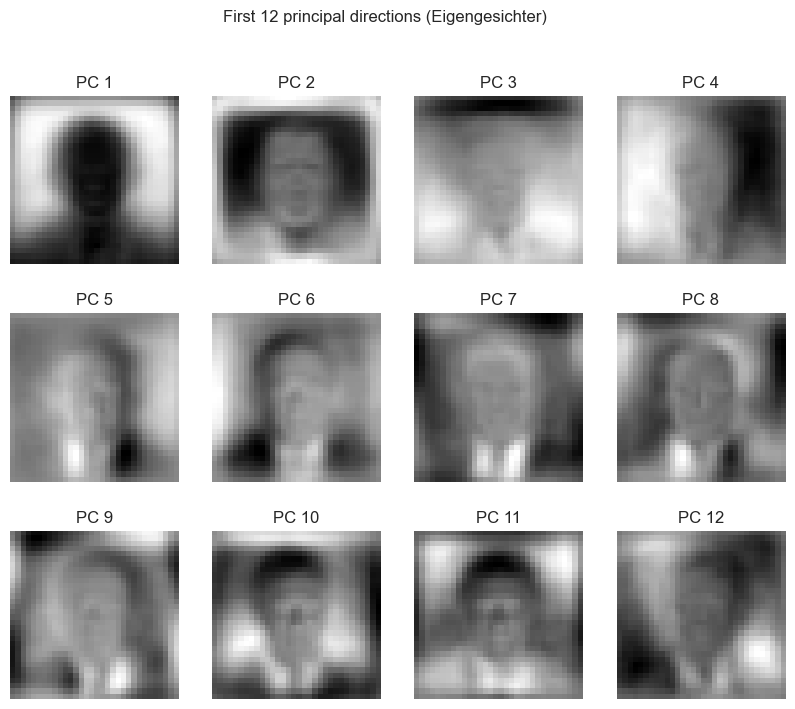


Interpretation: Die ersten Hauptkomponenten zeigen die dominanten Variationsrichtungen der Gesichtsdaten (Helligkeitsverteilungen, grobe Form, Lokalisierte Merkmale wie Augen/Mund). Die Eigenwerte geben an, wie viel Varianz jede Komponente erklärt.


In [18]:
# Compute mean and center data
mean_face = np.mean(X_train, axis=0)
Xc = X_train - mean_face

# SVD
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
# Eigenwerte der Kovarianzmatrix (bis auf Faktor) = S^2 / (N-1)
eigenvalues = (S ** 2) / (Xc.shape[0] - 1)

# Plot first 150 eigenvalues (or fewer wenn nicht vorhanden)
k_plot = min(150, len(eigenvalues))
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, k_plot + 1), eigenvalues[:k_plot], marker='o')
plt.xlabel('Index of principal component')
plt.ylabel('Eigenvalue (variance explained)')
plt.title('First {} eigenvalues (PCA)'.format(k_plot))
plt.grid(True)
plt.show()

# Plot first 12 eigenfaces (principal directions)
n_eigfaces = 12
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for i in range(n_eigfaces):
    ax = axes.flat[i]
    eigface = Vt[i].reshape(IMG_SIZE, IMG_SIZE)
    ax.imshow(eigface, cmap='gray')
    ax.set_title(f'PC {i + 1}')
    ax.axis('off')
plt.suptitle('First 12 principal directions (Eigengesichter)')
plt.show()

print(
    '\nInterpretation: Die ersten Hauptkomponenten zeigen die dominanten Variationsrichtungen der Gesichtsdaten (Helligkeitsverteilungen, grobe Form, Lokalisierte Merkmale wie Augen/Mund). Die Eigenwerte geben an, wie viel Varianz jede Komponente erklärt.')


d) Von den Testbildern wird nun ebenfalls der Mittelwert der Trainingsdaten abgezogen (s. Schritt 1 im PCA-Algorithmus). Projizieren Sie jedes der Trainings- und Testbilder auf die ersten 7 Eigengesichter, d.h. Sie erhalten so für jedes Trainings- und Testbild 7 Merkmale. Die Gesichtserkennung geschieht nun dadurch, dass Sie den euklidischen Abstand des Testbildes in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern berechnen. Die Person des am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator). Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es?

Nearest-neighbor accuracy (7 PCs): 0.1429 (1 correct out of 7)

Confusion matrix (rows: true, cols: predicted)
[[0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]]

Classification report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00         1
     Colin_Powell       0.00      0.00      0.00         1
  Donald_Rumsfeld       0.00      0.00      0.00         1
    George_W_Bush       0.00      0.00      0.00         1
Gerhard_Schroeder       0.50      1.00      0.67         1
      Hugo_Chavez       0.00      0.00      0.00         1
       Tony_Blair       0.00      0.00      0.00         1

         accuracy                           0.14         7
        macro avg       0.07      0.14      0.10         7
     weighted avg       0.07      0.14      0.10         7

Number of misclassified test images: 6
Test sample 0: true=Ariel_Sharon, predicted=Colin_Powe

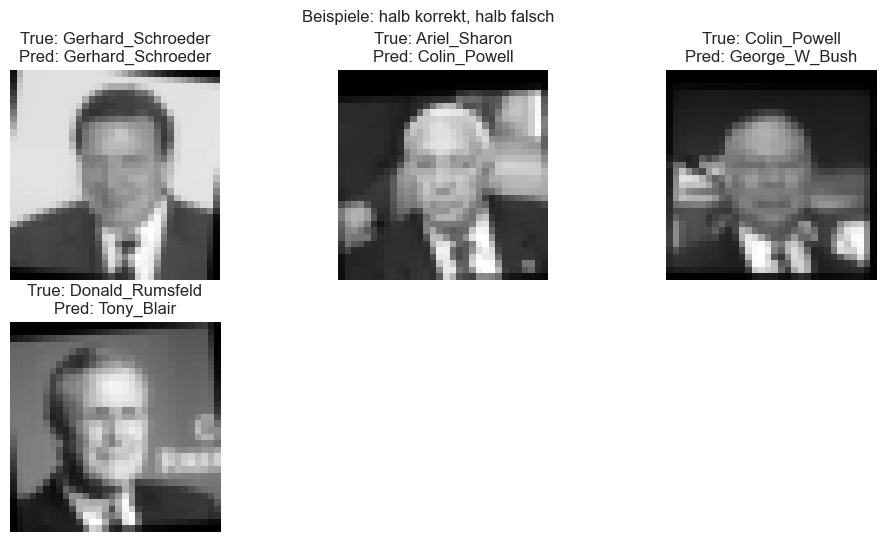

In [19]:
k = 7
components = Vt[:k, :]  # shape (k, D)

# Projektionen (scores)
scores_train = Xc @ components.T  # (N_train x k)
X_test_centered = X_test - mean_face
scores_test = X_test_centered @ components.T  # (N_test x k)

# Nearest neighbor classification in k-dim space
preds = []
for i in range(scores_test.shape[0]):
    dists = np.linalg.norm(scores_train - scores_test[i], axis=1)
    idx_min = np.argmin(dists)
    preds.append(Y_train[idx_min])
preds = np.array(preds)

# Evaluate
accuracy = np.mean(preds == Y_test)
print(f'Nearest-neighbor accuracy (7 PCs): {accuracy:.4f} ({(preds == Y_test).sum()} correct out of {len(preds)})')

# Confusion matrix and classification report
cm = confusion_matrix(Y_test, preds)
print('\nConfusion matrix (rows: true, cols: predicted)')
print(cm)

print('\nClassification report:')
print(classification_report(Y_test, preds, target_names=selected_people, zero_division=0))

# Show which test images were misclassified
mis_idx = np.where(preds != Y_test)[0]
print(f'Number of misclassified test images: {len(mis_idx)}')
for i in mis_idx[:20]:
    true_name = selected_people[Y_test[i]]
    pred_name = selected_people[preds[i]]
    print(f'Test sample {i}: true={true_name}, predicted={pred_name}')

# Visualize some correct / incorrect matches
n_show = 6
plt.figure(figsize=(12, 6))
correct_idx = np.where(preds == Y_test)[0]
for i, idx in enumerate(np.concatenate([correct_idx[:n_show // 2], mis_idx[:n_show // 2]])):
    plt.subplot(2, n_show // 2, i + 1)
    img = X_test[idx].reshape(IMG_SIZE, IMG_SIZE)
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {selected_people[Y_test[idx]]}\nPred: {selected_people[preds[idx]]}')
    plt.axis('off')
plt.suptitle('Beispiele: halb korrekt, halb falsch')
plt.show()



## 3. Naiver Bayesklassifikator zur Gesichtserkennung

Implementieren Sie den Gaussian-Naïve-Bayes-Klassifikator aus der Vorlesung. Testen Sie Ihre Implementierung am Datensatz ''Labeled Faces in the Wild'' aus Aufgabe 2, wiederum nur für Personen, für die mindestens 70 Bilder existieren. Teilen Sie Ihren Datensatz in 60 % Trainings- und 40% Testdaten (nach vorheriger Zufalls-Permutation der Reihenfolge) und skalieren Sie die Bilder wieder auf 1/8 der Originalgröße. Führen Sie anschließend eine Hauptkomponentenanalyse auf den Trainingsdaten durch und projizieren Sie sowohl Trainings- als auch Testbilder auf die ersten 7 Eigengesichter. Trainieren Sie Ihren GNB-Klassifikator auf dem Trainingsdatensatz als ''George-W.-Bush-Detektor'', d.h. alle zu dieser Person gehörigen Bilder werden mit 1 gelabelt, alle sonstigen mit –1. Werten Sie Ihren Klassifikator sowohl auf den Trainings- wie auf den unabhängigen Testdaten aus. Bestimmen Sie dafür jeweils die Detektionswahrscheinlichkeit, Richtig-Negativ-Rate, Fehlalarmrate und Falsch-Negativ-Rate.


In [21]:
import os
import glob
import skimage
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

np.random.seed(42)

# Einstellungen (falls in Notebook schon anders definiert, passen diese Zeilen an)
lfw_dir = 'lfw-funneled/lfw-deepfunneled/lfw-deepfunneled'
IMG_SIZE = 32  # aus Aufgabe 2
NEW_SIZE = max(1, IMG_SIZE // 8)  # 32 // 8 = 4
k = 7  # Anzahl Hauptkomponenten

# Finde Personen mit >=70 Bildern (falls selected_people nicht vorhanden)
people = [p for p in os.listdir(lfw_dir) if os.path.isdir(os.path.join(lfw_dir, p))]
counts = {p: len(glob.glob(os.path.join(lfw_dir, p, '*.jpg'))) for p in people}
selected_people = sorted([p for p, c in counts.items() if c >= 70])


# Hilfsfunktion wie in Aufgabe 2 (Grayscale, center-crop, resize auf IMG_SIZE)
def preprocess_image(img, size=IMG_SIZE):
    if img.ndim == 3:
        img = skimage.color.rgb2gray(img)
    h, w = img.shape
    m = min(h, w)
    top = (h - m) // 2
    left = (w - m) // 2
    img_cropped = img[top:top + m, left:left + m]
    img_resized = skimage.transform.resize(img_cropped, (size, size), anti_aliasing=True)
    return img_resized


# Lade alle Bilder aller ausgewählten Personen
X_all = []
Y_all = []
names_all = []
person_to_label = {p: i for i, p in enumerate(selected_people)}
for person in selected_people:
    files = sorted(glob.glob(os.path.join(lfw_dir, person, '*.jpg')))
    for f in files:
        img = imread(f)
        img_p = preprocess_image(img, size=IMG_SIZE)
        X_all.append(img_p)
        Y_all.append(person_to_label[person])
        names_all.append(person)
X_all = np.array(X_all)  # shape (N, IMG_SIZE, IMG_SIZE)
Y_all = np.array(Y_all)

# Zufalls-Permutation und 60/40 Split
N = X_all.shape[0]
perm = np.random.permutation(N)
X_all = X_all[perm]
Y_all = Y_all[perm]
names_all = np.array(names_all)[perm]

n_train = int(np.floor(0.6 * N))
X_tr = X_all[:n_train]
Y_tr = Y_all[:n_train]
names_tr = names_all[:n_train]
X_te = X_all[n_train:]
Y_te = Y_all[n_train:]
names_te = names_all[n_train:]


# Downscale auf 1/8 der vorherigen Größe (IMG_SIZE -> NEW_SIZE)
def downscale_set(X, new_size=NEW_SIZE):
    Xd = np.zeros((X.shape[0], new_size, new_size), dtype=np.float32)
    for i in range(X.shape[0]):
        Xd[i] = resize(X[i], (new_size, new_size), anti_aliasing=True)
    return Xd


X_tr_small = downscale_set(X_tr, NEW_SIZE)
X_te_small = downscale_set(X_te, NEW_SIZE)

# Flatten für PCA / Features
X_tr_flat = X_tr_small.reshape(X_tr_small.shape[0], -1)
X_te_flat = X_te_small.reshape(X_te_small.shape[0], -1)

# Binary labels für "George W. Bush"-Detektor: +1 für Bush, -1 sonst
# Suche passenden Namen in selected_people (häufig 'George_W_Bush')
pos_candidates = [p for p in selected_people if 'George' in p and 'Bush' in p]
if len(pos_candidates) > 0:
    pos_name = pos_candidates[0]
else:
    # Fallback: wähle erste Person (falls Bush nicht in selected_people)
    pos_name = selected_people[0]
pos_label = person_to_label[pos_name]

y_tr_bin = np.where(Y_tr == pos_label, 1, -1)
y_te_bin = np.where(Y_te == pos_label, 1, -1)

# PCA auf Trainingsdaten (zentrieren, SVD)
mean_face = np.mean(X_tr_flat, axis=0)
Xc_tr = X_tr_flat - mean_face
U, S, Vt = np.linalg.svd(Xc_tr, full_matrices=False)
components = Vt[:k, :]  # (k, D)

# Projektionen
scores_tr = Xc_tr @ components.T
scores_te = (X_te_flat - mean_face) @ components.T

# Gaussian Naive Bayes Training (je Klasse Mittelwert + Varianz pro Feature)
eps = 1e-6


def fit_gnb(X, y):
    classes = np.unique(y)
    params = {}
    priors = {}
    for c in classes:
        Xc = X[y == c]
        priors[c] = Xc.shape[0] / X.shape[0]
        params[c] = {
            'mean': np.mean(Xc, axis=0),
            'var': np.var(Xc, axis=0) + eps
        }
    return params, priors


def log_likelihood(x, params, priors):
    # x: (k,) single sample
    ll = {}
    for c, p in params.items():
        m = p['mean']
        v = p['var']
        # log Gaussian (independent features)
        ll_c = -0.5 * np.sum(np.log(2 * np.pi * v)) - 0.5 * np.sum(((x - m) ** 2) / v)
        ll[c] = ll_c + np.log(priors[c])
    return ll


params, priors = fit_gnb(scores_tr, y_tr_bin)


# Vorhersage-Funktion
def predict_gnb(X, params, priors):
    preds = []
    for i in range(X.shape[0]):
        ll = log_likelihood(X[i], params, priors)
        # wähle Klasse mit maximaler Posterior (log)
        pred = max(ll.items(), key=lambda kv: kv[1])[0]
        preds.append(pred)
    return np.array(preds)


preds_tr = predict_gnb(scores_tr, params, priors)
preds_te = predict_gnb(scores_te, params, priors)


# Auswertung: TP, TN, FP, FN und Raten
def rates(y_true, y_pred, pos=1):
    TP = np.sum((y_true == pos) & (y_pred == pos))
    FN = np.sum((y_true == pos) & (y_pred != pos))
    TN = np.sum((y_true != pos) & (y_pred != pos))
    FP = np.sum((y_true != pos) & (y_pred == pos))
    dp = TP / (TP + FN) if (TP + FN) > 0 else np.nan  # detection probability (TPR)
    tnr = TN / (TN + FP) if (TN + FP) > 0 else np.nan  # true negative rate
    far = FP / (FP + TN) if (FP + TN) > 0 else np.nan  # false alarm rate (FPR)
    fnr = FN / (FN + TP) if (FN + TP) > 0 else np.nan  # false negative rate
    return {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 'DP': dp, 'TNR': tnr, 'FAR': far, 'FNR': fnr}


train_stats = rates(y_tr_bin, preds_tr, pos=1)
test_stats = rates(y_te_bin, preds_te, pos=1)

print(f'Positive class used as "George W. Bush": `{pos_name}` (label {pos_label})\n')
print('Training set:')
for k, v in train_stats.items():
    print(f'  {k}: {v}')
print('\nTest set:')
for k, v in test_stats.items():
    print(f'  {k}: {v}')

# Optionale kurze Konfusionsmatrix-Ausgabe
print('\nConfusion matrix (train):\n', confusion_matrix(y_tr_bin, preds_tr, labels=[1, -1]))
print('\nConfusion matrix (test):\n', confusion_matrix(y_te_bin, preds_te, labels=[1, -1]))

Positive class used as "George W. Bush": `George_W_Bush` (label 3)

Training set:
  TP: 83
  TN: 403
  FP: 56
  FN: 230
  DP: 0.26517571884984026
  TNR: 0.8779956427015251
  FAR: 0.12200435729847495
  FNR: 0.7348242811501597

Test set:
  TP: 53
  TN: 257
  FP: 42
  FN: 164
  DP: 0.24423963133640553
  TNR: 0.8595317725752508
  FAR: 0.14046822742474915
  FNR: 0.7557603686635944

Confusion matrix (train):
 [[ 83 230]
 [ 56 403]]

Confusion matrix (test):
 [[ 53 164]
 [ 42 257]]
